# What is this challenge all about?

We are presented with multiple recordings (up to 100) for each of the 264 bird species in the training set. All birds live in or travel to North America. The recordings come from https://www.xeno-canto.org/ - a site where people upload their bird recordings.

Lets look at the data folder.

In [7]:
!ls data

birdsong-recognition.zip	 sample_submission.csv	train_resampled
example_test_audio		 test.csv		train_resampled.zip
example_test_audio_metadata.csv  train_audio
example_test_audio_summary.csv	 train.csv


Let's take a look at `train.csv`.

In [8]:
import pandas as pd

train = pd.read_csv('data/train.csv')
train.shape

(21375, 35)

In [9]:
train.head(3)

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
0,3.5,no,aldfly,1 (mono),2013-05-25,Not specified,25,XC134874.mp3,Not specified,Alder Flycatcher,...,134874,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135454.mp3,both,Alder Flycatcher,...,135454,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
2,4.0,no,aldfly,2 (stereo),2013-05-27,both,39,XC135455.mp3,both,Alder Flycatcher,...,135455,https://www.xeno-canto.org/135455,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...


How many different birds are there in the train set?

In [10]:
train.ebird_code.nunique()

264

This is what sampling rates across the recordings look like:

In [11]:
train.sampling_rate.value_counts()

44100 (Hz)    12693
48000 (Hz)     8373
22050 (Hz)      123
32000 (Hz)       93
24000 (Hz)       54
16000 (Hz)       34
11025 (Hz)        3
8000 (Hz)         2
Name: sampling_rate, dtype: int64

One of the organizers shared [on Kaggle](https://www.kaggle.com/c/birdsong-recognition/discussion/159943#893049) that all the recordings in the test set should be sampled at 32 kHz.

Let's resample the train set to 32 kHz.

#### Resampling

In [2]:
#export
import soundfile as sf
from pathlib import Path
import librosa
import numpy as np
from multiprocessing import Pool, cpu_count
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
mkdir data/train_resampled

In [ ]:
import os

for directory in Path('data/train_audio').iterdir():
    ebird_code = directory.name
    os.makedirs(f'data/train_resampled/{ebird_code}')

In [ ]:
#export
NUM_WORKERS = 6
SAMPLE_RATE = 32000

In [ ]:
def resample_audio(path):
    x = librosa.load(path, sr=SAMPLE_RATE, mono=True)[0]
    ebird_code = path.parent.name
    sf.write(f'data/train_resampled/{ebird_code}/{path.stem}.wav', x, SAMPLE_RATE)

In [ ]:
for directory in Path('data/train_audio').iterdir():
    file_paths = list(directory.iterdir())
    with Pool(NUM_WORKERS) as p:
        try:
            p.map(resample_audio, file_paths)
        except Exception as e:
            print(e)

#### Data Exploration

how many recordings do we have per species?

In [3]:
from collections import defaultdict

recs = defaultdict(list)
for directory in Path('data/train_resampled').iterdir():
    ebird_code = directory.name
    for file in directory.iterdir():
        recs[ebird_code].append((file, sf.info(file).duration))

In [4]:
counts = [len(recs[ebird]) for ebird in recs.keys()]
min(counts), max(counts)

(9, 100)

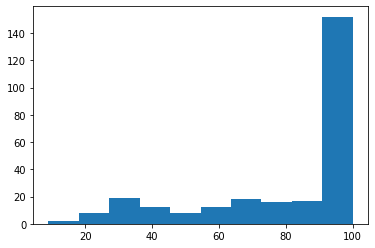

In [6]:
import matplotlib.pyplot as plt

plt.hist(counts);